## Цели и задачи работы

Цель исследования - построить нейронную сеть, которая сможет предсказывать температуру на поверхности звезды. 

Исходя из поставленной цели в ходе исследования будет решаться задача <b>регрессии</b>. В связи с этим в качестве метрики примем `RSME`.

Исходя из поставленной цели, в ходе исследования необходимо выполнить следующие задачи:
1. Провести предобработку исходного датасета.
2. Выполнить анализ исходных данных.
3. Построить несколько базовых нейронных сетей с целью выявить наиболее подходящую для достижения цели исследования. 
4. Произвести улучшение выбранной базовой модели. 

## Загрузка данных

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import phik
import torch
import torch.nn as nn
import plotly.graph_objects as go

from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

warnings.filterwarnings('ignore')

Загрузим исходный датасет и сохраним его в переменной `data_initial`

In [2]:
data_initial = pd.read_csv('6_class.csv')

data_initial.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Напишем функцию, которая примет на вход исходный датасет и выведет следующую информацию о содержащихся в нем данных:
1. название полей;
2. тип данных;
3. количество пропусков, а также их долю от общего числа значений;
4. минимальное и максимальное значения;
5. наличие значений булевого типа.

In [3]:
def introduction_to_data(df):
    parameters = dict()
    parameters['column name'] = list(df.columns)
    parameters['type'] = list(df.dtypes)
    parameters['non-null'] = list(df.count() - df.isna().sum())
    parameters['null_quantity'] = list(df.isna().sum())
    parameters['null_percentage'] = list((df.isna().sum()/df.count())*100)
    parameters['min'] = list(df.min())
    parameters['max'] = list(df.max())
    
    info = pd.DataFrame(parameters)
    info.loc[(info['max'] == 1) & (info['min'] == 0), 'is_bool'] = 'bool'
    info.loc[(info['type'] == 'object'), 'max'] = '-'
    info.loc[(info['type'] == 'object'), 'min'] = '-'
    info.loc[(info['type'] == 'object') | (info['max'] != 1) | (info['min'] != 0), 'is_bool'] = '-'

    return  display(info)

In [4]:
info = introduction_to_data(data_initial)

info

,column name,type,non-null,null_quantity,null_percentage,min,max,is_bool
0,Unnamed: 0,int64,240,0,0.0,0,239,-
1,Temperature (K),int64,240,0,0.0,1939,40000,-
2,Luminosity(L/Lo),float64,240,0,0.0,8e-05,849420,-
3,Radius(R/Ro),float64,240,0,0.0,0.0084,1948.5,-
4,Absolute magnitude(Mv),float64,240,0,0.0,-11.92,20.06,-
5,Star type,int64,240,0,0.0,0,5,-
6,Star color,object,240,0,0.0,-,-,-


Построим матрицу корреляции

In [5]:
phik_corr = data_initial.phik_matrix()

interval columns not set, guessing: ['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']


In [6]:
phik_corr

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
Unnamed: 0,1.000000,0.623984,0.655728,0.342545,0.741452,0.687374,0.652856
Temperature (K),0.623984,1.000000,0.561692,0.236090,0.709280,0.603203,0.741088
Luminosity(L/Lo),0.655728,0.561692,1.000000,0.574964,0.709456,0.654026,0.301080
Radius(R/Ro),0.342545,0.236090,0.574964,1.000000,0.512414,0.635115,0.000000
Absolute magnitude(Mv),0.741452,0.709280,0.709456,0.512414,1.000000,0.915921,0.785467
Star type,0.687374,0.603203,0.654026,0.635115,0.915921,1.000000,0.831411
Star color,0.652856,0.741088,0.301080,0.000000,0.785467,0.831411,1.000000


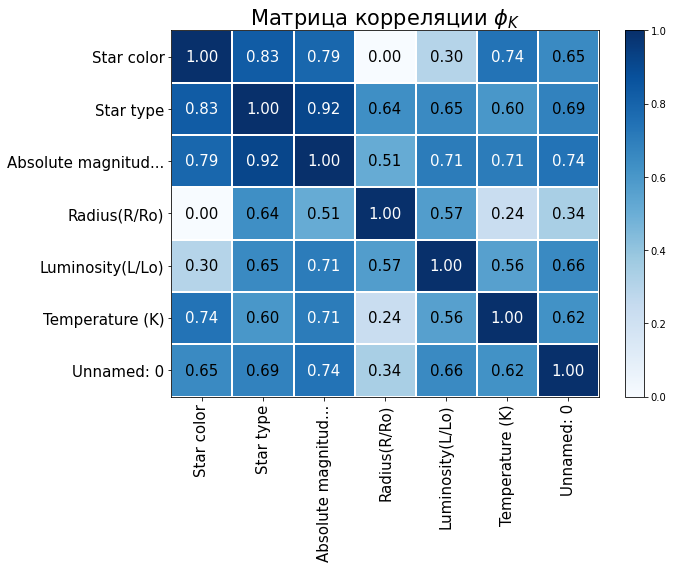

In [7]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Матрица корреляции $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

### Выводы по результатам предварительного просмотра данных

По результатам предварительного осмотра данных можно сделать слендующие выводы:
1. В представленных данных отсутствуют пропуски. 
2. Поле под названием `Unnamed: 0` является полем с индексами, так как при общем количестве строк в 240 значения указанного поля изменяются от 0 до 239. Данное поле следует удалить из датасет. 
3. Для полей `Luminosity(L/Lo)` и `Radius(R/Ro)`, содержащих количественные признаки, наблюдается значительный разброс значений. Чтобы нейронная сеть работала более корректно, признаки в данных столбцах следует масштабировать. 
4. Для целевого признака, содержащегося в поле `Temperature (K)` наибольшие значения коэффициента корреляции имеют поля `Star color` и `Absolute magnitude(Mv)`. При этом стоит отметить, что коэффициент корреляции почти по всем столбцам больше 0,5.

В дальнейшем при подготовке данных необходимо выполнить следующие действия:
1. Проверить данные на наличие явных и неявных дубликатов. 
2. Проверить данные на наличие выбросов и аномалий. 
3. Масштабировать признаки. 

In [8]:
data_prepared = data_initial.drop(columns='Unnamed: 0')

## Предобработка и анализ данных

### Поиск неявных дубликатов

In [9]:
cat_columns = ['Star color','Star type']

In [10]:
for i in cat_columns:
    print(f'Поле {i}')
    print(data_prepared[i].unique())
    print()

Поле Star color
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']

Поле Star type
[0 1 2 3 4 5]



В поле `Star color` обнаружено множество дубликатов - приведем написание категорий к нижнему регистру и заменим слитное написание и написание через дефис пробелом. 

<b>Для проверки правильности написания цветов </b> сверим их с гарвардской классификацией (`HARVARD SPECTRAL CLASSIFICATION`).
Исходя из данной классификации, замене подлежат также следующие цвета: `white-yellow`, `whitish`, `yellowish`.

В поле `Star type` неявных дубликатов не выявлено.

In [11]:
data_prepared['Star color'] = data_prepared['Star color'].str.lower()

In [12]:
data_prepared['Star color'] = data_prepared['Star color'].replace('blue white ','blue white').replace('blue-white','blue white')
data_prepared['Star color'] = data_prepared['Star color'].replace('white-yellow','yellow-white')
data_prepared['Star color'] = data_prepared['Star color'].replace('blue ','blue')
data_prepared['Star color'] = data_prepared['Star color'].replace('whitish','white')
data_prepared['Star color'] = data_prepared['Star color'].replace('yellowish','yellow')

In [13]:
data_prepared['Star color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'yellow-white', 'orange', 'yellow',
       'orange-red'], dtype=object)

### Поиск явных дубликатов

In [14]:
data_prepared_drop = data_prepared.drop_duplicates()

print(len(data_prepared))
print(len(data_prepared_drop))

240
240


Явных дубликатов не обнаружено

### Поиск выбросов

Напишем функцию, которая подсчитывает количество выбросов по каждому столбцу и выводит их долю от общего числа данных в датасете.

In [15]:
def outliers(df, column):
    initial_df = df
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    
    new_df = df.loc[(df[column] < lower) | (df[column] > upper)]
    
    initial = len(initial_df)
    new = len(new_df)
    ratio = (new/initial)*100
    
    maximum = df[column].max()
    minimum = df[column].min()
    
    print(
        "Столбец {}\nМаксимальное значение = {:.0f},\nМинимальное значение = {:.0f},\n"\
        "25-й квантиль = {:.0f},\n75-й квантиль = {:.0f},\n"\
        "Верхняя граница = {:.0f},\nНижняя граница = {:.0f},\nКоличество строк в исходном датасете = {:.0f},\n"\
        "Количество выбросов = {:.0f},\nДоля выбросов = {:.3f}\n".format(column,maximum,minimum,Q1,Q3,upper,lower,initial, new, ratio)
    )

In [16]:
for i in ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']:
    outliers(data_prepared, i)

Столбец Luminosity(L/Lo)
Максимальное значение = 849420,
Минимальное значение = 0,
25-й квантиль = 0,
75-й квантиль = 198050,
Верхняя граница = 495125,
Нижняя граница = -297075,
Количество строк в исходном датасете = 240,
Количество выбросов = 12,
Доля выбросов = 5.000

Столбец Radius(R/Ro)
Максимальное значение = 1948,
Минимальное значение = 0,
25-й квантиль = 0,
75-й квантиль = 43,
Верхняя граница = 107,
Нижняя граница = -64,
Количество строк в исходном датасете = 240,
Количество выбросов = 40,
Доля выбросов = 16.667

Столбец Absolute magnitude(Mv)
Максимальное значение = 20,
Минимальное значение = -12,
25-й квантиль = -6,
75-й квантиль = 14,
Верхняя граница = 44,
Нижняя граница = -36,
Количество строк в исходном датасете = 240,
Количество выбросов = 0,
Доля выбросов = 0.000



Как мы видим, в полях `Luminosity(L/Lo)` и `Radius(R/Ro)` присутствуют выбросы, при этом:
1. В поле `Luminosity(L/Lo)` доля выбросов составляет 5% от всего датасета, не будем удалять такой объем датасета. 
2. Нельзя однозначно утверждать, что выбросы в поле `Radius(R/Ro)` можно изменить без вреда для остального датасета, нам для этого не хватает компетенции. Оставим данное поле без изменений. 

### Графический анализ данных

In [17]:
fig_star_col = go.Figure()

fig_star_col.add_trace(
    go.Histogram(
        x = data_prepared['Star color'],
        marker_color='rgb(0,0,100)'
    )
)

fig_star_col.update_layout(title="Распределение данных в зависимости от цвета звезды",
                    xaxis_title="Цвет звезды",
                    yaxis_title="Количество",
                    bargap=0.15
                   )

fig_star_col.show()

In [18]:
fig_star_lum = go.Figure()

fig_star_lum.add_trace(
    go.Histogram(
        x = data_prepared['Luminosity(L/Lo)'],
        marker_color='rgb(0,0,100)'
    )
)

fig_star_lum.update_layout(title="Распределение данных в зависимости от относительной светимости",
                    xaxis_title="Относительная светимость",
                    yaxis_title="Количество",
                    bargap=0.15
                   )

fig_star_lum.show()

<b>Стоит отметить, что значительная часть значений в поле `Luminosity(L/Lo)` находится в правой части графика, что в купе с высоким коэффициентом корреляции (0.66) может сказаться на результатах работы сети.</b>

In [19]:
fig_star_type = go.Figure()

fig_star_type.add_trace(
    go.Histogram(
        x = data_prepared['Star type'],
        marker_color='rgb(0,0,100)'
    )
)

fig_star_type.update_layout(title="Распределение данных в зависимости от типа звезды",
                    xaxis_title="Тип звезды",
                    yaxis_title="Количество",
                    bargap=0.15
                   )

fig_star_type.show()

In [20]:
fig_star_rad = go.Figure()

fig_star_rad.add_trace(
    go.Histogram(
        x = data_prepared['Radius(R/Ro)'],
        marker_color='rgb(0,0,100)'
    )
)

fig_star_rad.update_layout(title="Распределение данных в зависимости от относительного радиуса",
                    xaxis_title="Относительный радиус",
                    yaxis_title="Количество",
                    bargap=0.15
                   )

fig_star_rad.show()

In [21]:
fig_star_mag = go.Figure()

fig_star_mag.add_trace(
    go.Histogram(
        x = data_prepared['Absolute magnitude(Mv)'],
        marker_color='rgb(0,0,100)'
    )
)

fig_star_mag.update_layout(title="Распределение данных в зависимости от абсолютной звездной величины",
                    xaxis_title="Тип звезды",
                    yaxis_title="Количество",
                    bargap=0.15
                   )

fig_star_mag.show()

### Разбиение исходного датасета на выборки, масштабирование и прямое кодирование признаков

Для прямого кодирования признаков воспользуемся функцией библиотеки Pandas `.get_dummies()`. При вызове функции также укажем аргумент `drop_first=True`, что позовлит избежать т.н. дамми-ловушки.

Для масштабирования признаков воспользуемся структурой `StandardScaler`, но для этого разделим выборку на обучающую и валидационную, а также выделим целевой признак. 

Ранее указанные для масштабирования столбцы сохраним в переменной `scale`.

Также выполним категоризацию признаков по полю `Star color` чтобы избежать ошибок на следующих этапах из-за категорий, в которые попадает небольшое количество значений. 

In [22]:
data_prepared['Star color'].value_counts()

red                   112
blue                   56
blue white             41
white                  12
yellow-white            9
yellowish white         3
yellow                  3
orange                  2
orange-red              1
pale yellow orange      1
Name: Star color, dtype: int64

Объединим последние 5 позиций в 1 категорию

In [23]:
data_prepared.loc[data_prepared['Star color'].isin(data_prepared['Star color'].value_counts().tail(5).index.tolist()), 'Star color'] = 'other'

In [24]:
data_prepared['Star color'].value_counts()

red             112
blue             56
blue white       41
white            12
other            10
yellow-white      9
Name: Star color, dtype: int64

In [25]:
target = data_prepared['Temperature (K)']
features = data_prepared.drop('Temperature (K)', axis=1)

In [26]:
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.3, 
    random_state=42,
    stratify=features['Star color'],                          
    shuffle=True
)

num = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)','Star type']
cat = ['Star color']    


col_transformer = ColumnTransformer(
                    transformers=[
                        ('ss', StandardScaler(), num),
                        ('ohe', OneHotEncoder(drop='first', sparse=False), cat)
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

In [27]:
features_train = col_transformer.fit_transform(features_train)
features_test = col_transformer.transform(features_test)  

In [28]:
features_train = torch.FloatTensor(features_train)
features_test = torch.FloatTensor(features_test)
target_train = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)

### Выводы по результатам предобработки и анализа данных

В ходе предобработки данных:
1. Устранены неявные дубликаты по полю `Star color`.
2. Обнаружены выбросы в полях `Luminosity(L/Lo)` и `Radius(R/Ro)`, при этом:
    1. В поле `Luminosity(L/Lo)` доля выбросов составляет 5% от всего датасета, эти выбросы можно удалить. 
    2. Нельзя однозначно утверждать, что выбросы в поле `Radius(R/Ro)` можно изменить без вреда для остального датасета, нам для этого не хватает компетенции. Оставим данное поле без изменений.

В результате графического анализа выявлено, что значительная часть значений в поле `Luminosity(L/Lo)` находится в правой части графика, что в купе с высоким коэффициентом корреляции (0.66) может сказаться на результатах работы сети. 

В ходе подготовки обучающей и тестовой выборки выполнены следующие действия:
1. Проведено прямое кодирование категориальных признаков. 
2. Проведено масштабирование количественных признаков.

## Построение базовой нейронной сети

Создадим несколько базовых нейронных сетей - будем менять функцию активации, количество скрытых слоев и количество нейронов. 

В качестве метрики примем RMSE.

### Базовая модель 1

В данной модели: 
1. 3 скрытых слоя; 
2. функция активации - `ReLU()`;
3. 1000 нейронов на каждом слое.

In [29]:
n_in_neurons = 9
n_hidden_neurons_1 = 1000
n_hidden_neurons_2 = 1000
n_hidden_neurons_3 = 1000
n_out_neurons = 1 

In [30]:
net_1 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_out_neurons)
)

optimizer = torch.optim.Adam(net_1.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_1.train()
    optimizer.zero_grad()
    
    preds = net_1(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_1.eval()
            test_preds = net_1(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13330.2109)
tensor(7196.6836)
tensor(5071.9233)
tensor(4457.4941)
tensor(4370.7378)
tensor(4426.3608)
tensor(4493.7495)
tensor(4667.4219)
tensor(4840.1660)
tensor(4899.3989)
tensor(4889.8325)


In [31]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_1 = {}
df_1['Actual'] = target_test
df_1['Predicted'] = test_preds
df_1 = pd.DataFrame(df_1)
print(df_1)

     Actual     Predicted
0    3463.0   3134.772461
1    7100.0    875.189819
2    3752.0   2090.677734
3    3095.0   3292.237793
4    2650.0   2933.456543
..      ...           ...
67   8930.0   9033.605469
68  19923.0  25622.996094
69   3574.0   6677.494141
70   2871.0   2979.238037
71   7282.0  10137.290039

[72 rows x 2 columns]


In [32]:
fig_1 = go.Figure()

fig_1.add_trace(
    go.Bar(
        x = df_1.index, 
        y = df_1['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_1.add_trace(
    go.Bar(
        x = df_1.index, 
        y = df_1['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_1.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_1.show()

<b>График показывает, что наибольшие трудности у сети появляются при предсказании температур для звезд с высокой температурой на поверхности - предсказание в каждом из случаев ниже. Попробуем увеличить количество слоев</b>

### Базовая модель 2

В данной модели: 
1. 5 скрытых слоев; 
2. функция активации - `ReLU()`;
3. 1000 нейронов на каждом слое.

In [33]:
n_in_neurons = 9
n_hidden_neurons_1 = 1000
n_hidden_neurons_2 = 1000
n_hidden_neurons_3 = 1000
n_hidden_neurons_4 = 1000
n_hidden_neurons_5 = 1000
n_out_neurons = 1 

In [34]:
net_2 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_2.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_2.train()
    optimizer.zero_grad()
    
    preds = net_2(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_2.eval()
            test_preds = net_2(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13330.6016)
tensor(4703.6099)
tensor(4719.1001)
tensor(4442.8994)
tensor(4471.5664)
tensor(4252.2095)
tensor(4034.5486)
tensor(4074.1475)
tensor(4021.1863)
tensor(3668.4448)
tensor(3529.5161)


In [35]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_2 = {}
df_2['Actual'] = target_test
df_2['Predicted'] = test_preds
df_2 = pd.DataFrame(df_2)
print(df_2)

     Actual     Predicted
0    3463.0   2910.401855
1    7100.0   4212.903320
2    3752.0   3985.748291
3    3095.0   3304.943115
4    2650.0   2852.616455
..      ...           ...
67   8930.0   8401.390625
68  19923.0  23013.718750
69   3574.0   3580.163330
70   2871.0   2759.996338
71   7282.0  10745.459961

[72 rows x 2 columns]


In [36]:
fig_2 = go.Figure()

fig_2.add_trace(
    go.Bar(
        x = df_2.index, 
        y = df_2['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_2.add_trace(
    go.Bar(
        x = df_2.index, 
        y = df_2['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_2.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_2.show()

<b>Сеть стала лучше определять значения для звезд с высокой температурой на поверхности, значение метрики RMSE также уменьшилось. Попробуем изменить функцию активации</b>

### Базовая модель 3

В данной модели: 
1. 5 скрытых слоев; 
2. функция активации - `Sigmoid()`;
3. 1000 нейронов на каждом слое.

In [37]:
n_in_neurons = 9
n_hidden_neurons_1 = 1000
n_hidden_neurons_2 = 1000
n_hidden_neurons_3 = 1000
n_hidden_neurons_4 = 1000
n_hidden_neurons_5 = 1000
n_out_neurons = 1 

In [38]:
net_3 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_3.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_3.train()
    optimizer.zero_grad()
    
    preds = net_3(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_3.eval()
            test_preds = net_3(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13328.7080)
tensor(13280.9551)
tensor(13236.7051)
tensor(13192.5098)
tensor(13147.5615)
tensor(13102.5264)
tensor(13056.9326)
tensor(13011.4248)
tensor(12965.1406)
tensor(12918.6855)
tensor(12872.9717)


In [39]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_3 = {}
df_3['Actual'] = target_test
df_3['Predicted'] = test_preds
df_3 = pd.DataFrame(df_3)
print(df_3)

     Actual   Predicted
0    3463.0  622.829224
1    7100.0  622.829224
2    3752.0  622.829224
3    3095.0  622.829224
4    2650.0  622.829224
..      ...         ...
67   8930.0  622.829224
68  19923.0  622.829224
69   3574.0  622.829224
70   2871.0  622.829224
71   7282.0  622.829224

[72 rows x 2 columns]


In [40]:
fig_3 = go.Figure()

fig_3.add_trace(
    go.Bar(
        x = df_3.index, 
        y = df_3['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_3.add_trace(
    go.Bar(
        x = df_3.index, 
        y = df_3['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_3.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_3.show()

<b>Данная базовая модель работает хуже, чем модель под номером 2</b>

### Базовая модель 4

В данной модели: 
1. 5 скрытых слоев; 
2. функция активации - `Tanh()`;
3. 1000 нейронов на каждом слое.

In [41]:
n_in_neurons = 9
n_hidden_neurons_1 = 1000
n_hidden_neurons_2 = 1000
n_hidden_neurons_3 = 1000
n_hidden_neurons_4 = 1000
n_hidden_neurons_5 = 1000
n_out_neurons = 1 

In [42]:
net_4 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_4.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_4.train()
    optimizer.zero_grad()
    
    preds = net_4(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_4.eval()
            test_preds = net_4(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13329.9678)
tensor(13244.0264)
tensor(13169.4043)
tensor(13095.5967)
tensor(13022.4160)
tensor(12949.8076)
tensor(12877.7461)
tensor(12806.2178)
tensor(12735.2188)
tensor(12664.7451)
tensor(12595.4922)


In [43]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_4 = {}
df_4['Actual'] = target_test
df_4['Predicted'] = test_preds
df_4 = pd.DataFrame(df_4)
print(df_4)

     Actual    Predicted
0    3463.0  1009.813721
1    7100.0  1009.813721
2    3752.0  1009.813721
3    3095.0  1009.813721
4    2650.0  1009.813721
..      ...          ...
67   8930.0  1009.813721
68  19923.0  1009.813721
69   3574.0  1009.813721
70   2871.0  1009.813721
71   7282.0  1009.813721

[72 rows x 2 columns]


In [44]:
fig_4 = go.Figure()

fig_4.add_trace(
    go.Bar(
        x = df_4.index, 
        y = df_4['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_4.add_trace(
    go.Bar(
        x = df_4.index, 
        y = df_4['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_4.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_4.show()

<b>Данная базовая модель работает хуже, чем модель под номером 2</b>

### Базовая модель 5

В данной модели: 
1. 5 скрытых слоев; 
2. функции активации - `ReLU()`,`Sigmoid()`,`Tanh()`;
3. 1000 нейронов на каждом слое.

In [45]:
n_in_neurons = 9
n_hidden_neurons_1 = 1000
n_hidden_neurons_2 = 1000
n_hidden_neurons_3 = 1000
n_hidden_neurons_4 = 1000
n_hidden_neurons_5 = 1000
n_out_neurons = 1 

In [46]:
net_5 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_5.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_5.train()
    optimizer.zero_grad()
    
    preds = net_5(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_5.eval()
            test_preds = net_5(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13328.8672)
tensor(9279.1240)
tensor(8908.8145)
tensor(8910.0107)
tensor(8910.0186)
tensor(5680.3340)
tensor(4795.8042)
tensor(5183.8081)
tensor(4695.9116)
tensor(4215.5884)
tensor(4063.7649)


In [47]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_5 = {}
df_5['Actual'] = target_test
df_5['Predicted'] = test_preds
df_5 = pd.DataFrame(df_5)
print(df_5)

     Actual     Predicted
0    3463.0   3146.536621
1    7100.0   7440.766602
2    3752.0   4382.371094
3    3095.0   3388.552734
4    2650.0   3011.329346
..      ...           ...
67   8930.0   7775.949707
68  19923.0  23592.867188
69   3574.0   3689.953125
70   2871.0   2871.394775
71   7282.0  21711.732422

[72 rows x 2 columns]


In [48]:
fig_5 = go.Figure()

fig_5.add_trace(
    go.Bar(
        x = df_5.index, 
        y = df_5['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_5.add_trace(
    go.Bar(
        x = df_5.index, 
        y = df_5['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_5.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_5.show()

<b>Данная базовая модель работает хуже, чем модель под номером 2</b>

### Вывод по результатам построения базовой модели

По результатам анализа работы моделей для работы была выбрана базовая модель №2 со следующими параметрами:
1. 5 скрытых слоев; 
2. функция активации - `ReLU()`;
3. 1000 нейронов на каждом слое.

## Улучшение нейронной сети

### Batch Normalization

In [49]:
net_bn = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_3),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_4),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_5),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_bn.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_bn.train()
    optimizer.zero_grad()
    
    preds = net_bn(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_bn.eval()
            test_preds = net_bn(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13331.0449)
tensor(13243.6621)
tensor(13124.7393)
tensor(12972.0225)
tensor(12711.5029)
tensor(12420.8711)
tensor(12016.3857)
tensor(11665.4941)
tensor(11167.5459)
tensor(10657.9492)
tensor(10112.0342)


In [50]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_bn = {}
df_bn['Actual'] = target_test
df_bn['Predicted'] = test_preds
df_bn = pd.DataFrame(df_bn)
print(df_bn)

     Actual    Predicted
0    3463.0  -530.814941
1    7100.0  1316.833008
2    3752.0  -411.074860
3    3095.0  -472.825043
4    2650.0  -568.705078
..      ...          ...
67   8930.0  1271.137451
68  19923.0  7558.516113
69   3574.0  -403.854645
70   2871.0  -563.539185
71   7282.0  4343.213379

[72 rows x 2 columns]


In [51]:
fig_bn = go.Figure()

fig_bn.add_trace(
    go.Bar(
        x = df_bn.index, 
        y = df_bn['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_bn.add_trace(
    go.Bar(
        x = df_bn.index, 
        y = df_bn['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_bn.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_bn.show()

### Dropout

#### Значение p=0.1

In [52]:
net_do_1 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_do_1.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_do_1.train()
    optimizer.zero_grad()
    
    preds = net_do_1(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_do_1.eval()
            test_preds = net_do_1(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13330.5518)
tensor(4724.8101)
tensor(4568.5088)
tensor(4618.8164)
tensor(4556.7261)
tensor(4507.2290)
tensor(4318.4468)
tensor(4224.9424)
tensor(3968.2302)
tensor(4261.9375)
tensor(3884.6729)


In [53]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_do_1 = {}
df_do_1['Actual'] = target_test
df_do_1['Predicted'] = test_preds
df_do_1 = pd.DataFrame(df_do_1)
print(df_do_1)

     Actual     Predicted
0    3463.0   3246.656250
1    7100.0   6379.769531
2    3752.0   3959.069092
3    3095.0   3431.015137
4    2650.0   3169.526611
..      ...           ...
67   8930.0   8153.163574
68  19923.0  24060.794922
69   3574.0   3824.202148
70   2871.0   3244.929443
71   7282.0  13699.666992

[72 rows x 2 columns]


In [54]:
fig_do = go.Figure()

fig_do.add_trace(
    go.Bar(
        x = df_do_1.index, 
        y = df_do_1['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_do.add_trace(
    go.Bar(
        x = df_do_1.index, 
        y = df_do_1['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_do.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_do.show()

#### Значение p=0.3

In [55]:
net_do_2 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_do_2.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_do_2.train()
    optimizer.zero_grad()
    
    preds = net_do_2(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_do_2.eval()
            test_preds = net_do_2(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13330.6201)
tensor(4861.4429)
tensor(4534.6895)
tensor(4589.3501)
tensor(4699.8813)
tensor(4668.7803)
tensor(4733.6152)
tensor(4412.1582)
tensor(4298.8330)
tensor(4807.6431)
tensor(4447.1895)


In [56]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_do_2 = {}
df_do_2['Actual'] = target_test
df_do_2['Predicted'] = test_preds
df_do_2 = pd.DataFrame(df_do_2)
print(df_do_2)

     Actual     Predicted
0    3463.0   3340.022461
1    7100.0   4720.095215
2    3752.0   3743.205078
3    3095.0   3520.898438
4    2650.0   3270.444824
..      ...           ...
67   8930.0   9711.011719
68  19923.0  21963.062500
69   3574.0   3405.049805
70   2871.0   3310.909668
71   7282.0  16874.878906

[72 rows x 2 columns]


In [57]:
fig_do = go.Figure()

fig_do.add_trace(
    go.Bar(
        x = df_do_2.index, 
        y = df_do_2['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_do.add_trace(
    go.Bar(
        x = df_do_2.index, 
        y = df_do_2['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_do.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_do.show()

#### Значение p=0.5

In [58]:
net_do_3 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_5, n_out_neurons)
)

optimizer = torch.optim.Adam(net_do_3.parameters(), lr=1.0e-3)

loss = nn.MSELoss()

num_epochs = 1000

for epoch in range(num_epochs):
    net_do_3.train()
    optimizer.zero_grad()
    
    preds = net_do_3(features_train).flatten()
    
    loss_value = torch.sqrt(loss(preds, target_train))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == max(range(num_epochs)):
        with torch.no_grad():
            net_do_3.eval()
            test_preds = net_do_3(features_test).flatten()
            loss_rmse = torch.sqrt(loss(test_preds, target_test))
            print(loss_rmse)

tensor(13330.7422)
tensor(5259.5522)
tensor(4550.1318)
tensor(4464.6147)
tensor(4484.7617)
tensor(4380.8164)
tensor(4760.6650)
tensor(4538.6001)
tensor(4732.9434)
tensor(4492.3462)
tensor(4631.8228)


In [59]:
test_preds = [test_preds[x].item() for x in range(len(test_preds))]

df_do_3 = {}
df_do_3['Actual'] = target_test
df_do_3['Predicted'] = test_preds
df_do_3 = pd.DataFrame(df_do_3)
print(df_do_3)

     Actual     Predicted
0    3463.0   3139.450439
1    7100.0   5105.043457
2    3752.0   3354.107910
3    3095.0   3289.897949
4    2650.0   3044.379639
..      ...           ...
67   8930.0   9154.006836
68  19923.0  20191.525391
69   3574.0   3258.898926
70   2871.0   3060.272949
71   7282.0  17863.666016

[72 rows x 2 columns]


In [60]:
fig_do = go.Figure()

fig_do.add_trace(
    go.Bar(
        x = df_do_3.index, 
        y = df_do_3['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_do.add_trace(
    go.Bar(
        x = df_do_3.index, 
        y = df_do_3['Predicted'],
        name='Предсказания',
        marker_color='rgb(0,200,200)'
    )
)

fig_do.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.3, orientation="h"),
                   )

fig_do.show()

### Выводы по результатам улучшения модели

<b>Значительного улучшения метрики `RMSE` получить не удалось. Видно, что модель все также плохо определяет звезды с высокой температурой на поверхности, что, возможно, объясняется небольшим количеством таких звезд в выборке.</b>

## Общие выводы

Выведем на общий график результаты предсказаний базовой модели и результаты, полученные после применения методов `Batch Normalization` и `Dropout`, а также фактические температуры звезд

In [61]:
fig_final = go.Figure()

fig_final.add_trace(
    go.Bar(
        x = df_2.index, 
        y = df_2['Actual'],
        name='Фактическая температура',
        marker_color='rgb(0,0,100)'
    )
)

fig_final.add_trace(
    go.Bar(
        x = df_2.index, 
        y = df_2['Predicted'],
        name='Предсказания базовой модели',
        marker_color='rgb(0,200,200)'
    )
)

fig_final.add_trace(
    go.Bar(
        x = df_bn.index, 
        y = df_bn['Predicted'],
        name='Предсказания с Batch Normalization',
        marker_color='rgb(0,150,150)'
    )
)

fig_final.add_trace(
    go.Bar(
        x = df_do_1.index, 
        y = df_do_1['Predicted'],
        name='Предсказания с Dropout',
        marker_color='rgb(0,100,200)'
    )
)

fig_final.update_layout(title="Сравнение предсказаний нейронной сети и фактических температур",
                    xaxis_title="Условный номер звезды",
                    yaxis_title="Температура звезды, К",
                    legend=dict(x=.5, xanchor="center", yanchor="bottom", y=-.7, orientation="h"),
                    xaxis=dict(rangeslider=dict(visible=True),type="linear")
                   )

fig_final.show()

В ходе выполнения работы выполнены следующие действия:

<b>Предварительный осмотр данных</b>

По результатам предварительного осмотра данных можно сделать слендующие выводы:
1. В представленных данных отсутствуют пропуски. 
2. Поле под названием `Unnamed: 0` является полем с индексами, так как при общем количестве строк в 240 значения указанного поля изменяются от 0 до 239. Данное поле следует удалить из датасет. 
3. Для полей `Luminosity(L/Lo)` и `Radius(R/Ro)`, содержащих количественные признаки, наблюдается значительный разброс значений. Чтобы нейронная сеть работала более корректно, признаки в данных столбцах следует масштабировать. 
4. Для целевого признака, содержащегося в поле `Temperature (K)` наибольшие значения коэффициента корреляции имеют поля `Star color` и `Absolute magnitude(Mv)`. При этом стоит отметить, что коэффициент корреляции почти по всем столбцам больше 0,5.

<b>Предобработка и анализ данных</b>

В ходе предобработки данных:
1. Устранены неявные дубликаты по полю `Star color`.
2. Обнаружены выбросы в полях `Luminosity(L/Lo)` и `Radius(R/Ro)`, при этом:
    1. В поле `Luminosity(L/Lo)` доля выбросов составляет 5% от всего датасета, эти выбросы можно удалить. 
    2. Нельзя однозначно утверждать, что выбросы в поле `Radius(R/Ro)` можно изменить без вреда для остального датасета, нам для этого не хватает компетенции. Оставим данное поле без изменений.

В результате графического анализа выявлено, что значительная часть значений в поле `Luminosity(L/Lo)` находится в правой части графика, что в купе с высоким коэффициентом корреляции (0.66) может сказаться на результатах работы сети. 

В ходе подготовки обучающей и тестовой выборки выполнены следующие действия:
1. Проведено прямое кодирование категориальных признаков. 
2. Проведено масштабирование количественных признаков.

<b>Построение и анализ работы разных бызовых моделей</b>

По результатам анализа работы моделей для работы была выбрана базовая модель №2 со следующими параметрами:
1. 5 скрытых слоев; 
2. функция активации - `ReLU()`;
3. 1000 нейронов на каждом слое.

<b>Улучшение нейронной сети</b>

Значительного улучшения метрики `RMSE` получить не удалось. 
    
    
<b>Видно (в том числе на последнем графике), что модель все также плохо определяет звезды с высокой температурой на поверхности, что, возможно, объясняется небольшим количеством таких звезд в выборке.</b>